# Static comparison vs init (latest vs epoch_0)

- Columns: Block 1 (left), Block 2 (right)
9
1
  2) Singular values of B̄ (x: model configs incl. init, y: SVs; violins)
  3) Singular values of C̄ (same layout)
  4) Singular values of GLU W1 (same layout)
  5) Singular values of GLU W2 (same layout)

Configs use alias "latest"; init is baseline ("1-5S window (baseline)") at alias "epoch_0" and is plotted in black.

In [68]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import (
    SSMFoundationalDecoder,
    SSMDownstreamDecoder,
    discretize_zoh,
)
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
from typing import Any, BinaryIO

WRITE_FIG_DIR = "/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures"


def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    Lambda_bar = jnp.concat([Lambda_bar, jnp.conj(Lambda_bar)])
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from dataclasses import dataclass
from typing import List, Dict, Any
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch


# Reuse: get_discretized_ssm_parameters, FOUR_CONFIGS, load_model_and_state_from_checkpoint_wandb
@dataclass
class ModelConfig:
    label: str
    artifact_prefix: (
        str  # e.g., 'melinajingting-ucl/foundational_ssm_pretrain/<artifact_name>'
    )
    model_cls: Any  # SSMFoundationalDecoder or SSMDownstreamDecoder


@dataclass
class StaticConfig:
    label: str
    artifact_prefix: str
    model_cls: Any


# Helper to test presence of data for a matrix key


def any_data_for_key(
    init_specs, latest_specs_by_label, key: str, blocks_to_plot, config_labels
) -> bool:
    for blk in blocks_to_plot:
        if init_specs[blk][key].size:
            return True
        for label in config_labels:
            if latest_specs_by_label[label][blk][key].size:
                return True
    return False


# Violin helper that keeps empty slots and removes per-row titles


def violin_for_matrix(
    init_specs,
    latest_specs_by_label,
    blocks_to_plot,
    config_labels,
    ax_grid,
    color_map,
    row_idx: int,
    key: str,
    ylabel: str,
):
    cat_order = ["Init"] + config_labels
    for c, blk in enumerate(blocks_to_plot):
        ax = ax_grid[row_idx, c]
        positions = np.arange(1, len(cat_order) + 1)
        xlim = (0.5, len(cat_order) + 0.5)
        for i, lab in enumerate(cat_order):
            if lab == "Init":
                vals = np.asarray(init_specs[blk][key]).ravel()
                color = "black"
                edge = "black"
                alpha = 0.6
            else:
                vals = (
                    np.asarray(
                        latest_specs_by_label.get(lab, [{}])[blk].get(key, np.array([]))
                    ).ravel()
                    if lab in latest_specs_by_label
                    else np.array([])
                )
                color = color_map.get(lab, "gray")
                edge = "white"
                alpha = 0.85
            if vals.size:
                parts = ax.violinplot(
                    [np.abs(vals)],
                    positions=[positions[i]],
                    showmeans=False,
                    showextrema=False,
                    showmedians=False,
                )
                body = parts["bodies"][0]
                body.set_facecolor(color)
                body.set_edgecolor(edge)
                body.set_alpha(alpha)
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xlabel("")
        if c == 0:
            ax.set_ylabel(ylabel)
        ax.grid(alpha=0.3)


def load_model_by_alias(prefix: str, alias: str, model_cls: Any):
    artifact_full = f"{prefix}:{alias}"
    model, state, meta = load_model_and_state_from_checkpoint_wandb(
        artifact_full, model_cls=model_cls
    )
    return model


def collect_block_spectra(model) -> List[Dict[str, np.ndarray]]:
    """For each block, return dict of arrays: A_eigs (complex), B_bar_svs, C_bar_svs, GLU_W1_svs, GLU_W2_svs."""
    blocks = []
    for block in model.ssm_blocks:
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(block.ssm)
        entry: Dict[str, np.ndarray] = {}
        # A eigenvalues (complex)
        entry["A_eigs"] = np.asarray(np.array(Lambda_bar))
        # Singular values
        try:
            entry["B_bar_svs"] = np.asarray(jnp.linalg.svd(B_bar, compute_uv=False))
        except Exception:
            entry["B_bar_svs"] = np.array([])
        try:
            entry["C_bar_svs"] = np.asarray(jnp.linalg.svd(C_tilde, compute_uv=False))
        except Exception:
            entry["C_bar_svs"] = np.array([])
        # GLU weights
        if (
            hasattr(block, "glu")
            and hasattr(block.glu, "w1")
            and hasattr(block.glu, "w2")
        ):
            try:
                entry["GLU_W1_svs"] = np.asarray(
                    jnp.linalg.svd(jnp.asarray(block.glu.w1.weight), compute_uv=False)
                )
            except Exception:
                entry["GLU_W1_svs"] = np.array([])
            try:
                entry["GLU_W2_svs"] = np.asarray(
                    jnp.linalg.svd(jnp.asarray(block.glu.w2.weight), compute_uv=False)
                )
            except Exception:
                entry["GLU_W2_svs"] = np.array([])
        else:
            entry["GLU_W1_svs"] = np.array([])
            entry["GLU_W2_svs"] = np.array([])
        blocks.append(entry)
    return blocks

In [59]:
# Use the same configs already defined in the notebook (FOUR_CONFIGS)
# Baseline init (epoch_0) comes from the first config (1-5S window (baseline))
MODEL_CONFIGS = [
    StaticConfig(
        "Baseline",
        "melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint",
        SSMFoundationalDecoder,
    ),
    StaticConfig(
        "Fixed 1S window",
        "melinajingting-ucl/foundational_ssm_pretrain/l2_with_context_reaching_1Swindow_checkpoint",
        SSMFoundationalDecoder,
    ),
    # StaticConfig("With context", "melinajingting-ucl/foundational_ssm_pretrain/l2_with_context_reaching_checkpoint", SSMFoundationalDecoder),
    StaticConfig(
        "No GLU",
        "melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint",
        SSMFoundationalDecoder,
    ),
    StaticConfig(
        "Freeze A",
        "melinajingting-ucl/foundational_ssm_pretrain/l2_freeze_a_reaching_checkpoint",
        SSMFoundationalDecoder,
    ),
    # StaticConfig("4 Layers", "melinajingting-ucl/foundational_ssm_pretrain/l4_reaching_checkpoint", SSMFoundationalDecoder),
]

BASELINE_LABEL = MODEL_CONFIGS[0].label
BASELINE_PREFIX = MODEL_CONFIGS[0].artifact_prefix
BASELINE_MODELCLS = MODEL_CONFIGS[0].model_cls

ALL_CONFIGS: List[StaticConfig] = [
    StaticConfig(cfg.label, cfg.artifact_prefix, cfg.model_cls) for cfg in MODEL_CONFIGS
]

# Load init (epoch_0) from the baseline and latest for each config
init_model = load_model_by_alias(BASELINE_PREFIX, "epoch_0", BASELINE_MODELCLS)
init_specs = collect_block_spectra(init_model)

latest_specs_by_label: Dict[str, List[Dict[str, np.ndarray]]] = {}
for cfg in MODEL_CONFIGS:
    try:
        m_latest = load_model_by_alias(cfg.artifact_prefix, "latest", cfg.model_cls)
        latest_specs_by_label[cfg.label] = collect_block_spectra(m_latest)
    except Exception as e:
        print(f"Skip {cfg.label} (latest): {e}")

# Determine which blocks to plot based on init model
num_blocks = len(init_specs)
blocks_to_plot = list(range(min(2, num_blocks)))

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


In [ ]:
# Baseline across epochs: build figures with A-eigs and offset histograms for singular values
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Which epochs to attempt; missing ones are skipped gracefully
EPOCHS = [500, 400, 300, 200, 100, 0]

# Collect spectra per epoch for the Baseline model
spectra_by_epoch: Dict[int, List[Dict[str, np.ndarray]]] = {}
for ep in EPOCHS:
    try:
        m_ep = load_model_by_alias(BASELINE_PREFIX, f"epoch_{ep}", BASELINE_MODELCLS)
        spectra_by_epoch[ep] = collect_block_spectra(m_ep)
    except Exception as e:
        print(f"Skip epoch_{ep}: {e}")

available_epochs = [ep for ep in EPOCHS if ep in spectra_by_epoch]
if not available_epochs:
    raise RuntimeError("No baseline epochs available to plot.")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


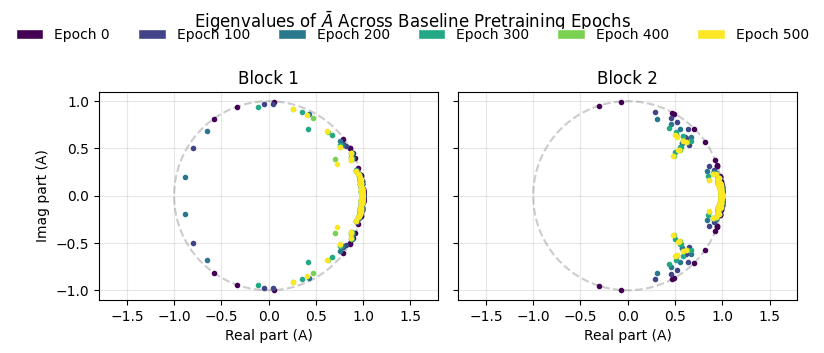

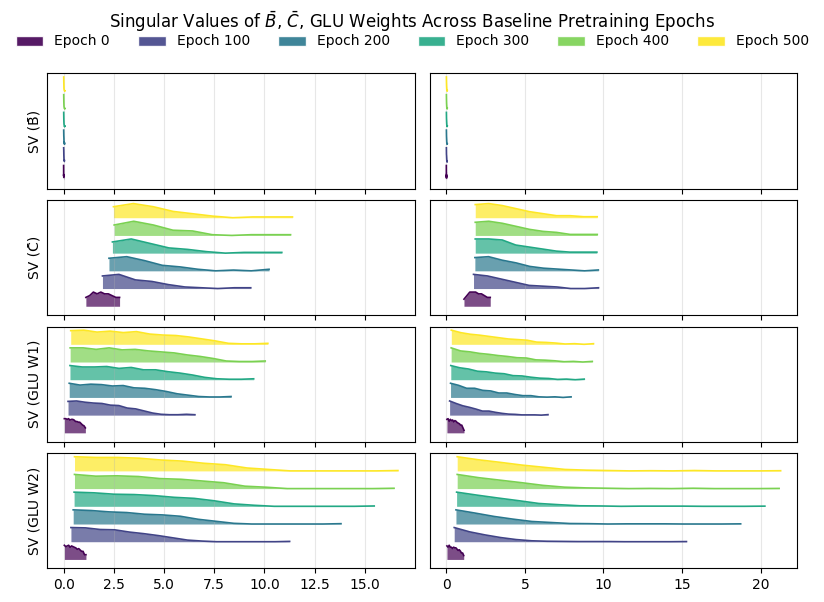

In [ ]:
# Determine blocks to plot from the first available epoch
probe_epoch = available_epochs[0]
num_blocks = len(spectra_by_epoch[probe_epoch])
blocks_to_plot = list(range(min(2, num_blocks)))

# ---------- Figure 1: A eigenvalues across epochs (Baseline only) ----------
figA, axesA = plt.subplots(
    1, max(1, len(blocks_to_plot)), figsize=(8, 3.5), sharey="row"
)
axesA = np.atleast_1d(axesA)

# color map for epochs
cmap = plt.cm.viridis
colors_ep = {
    ep: cmap(i / max(1, len(available_epochs) - 1))
    for i, ep in enumerate(available_epochs)
}

theta = np.linspace(0, 2 * np.pi, 256)
for c, blk in enumerate(blocks_to_plot):
    ax = axesA[c]
    # unit circle
    ax.plot(np.cos(theta), np.sin(theta), linestyle="--", color="gray", alpha=0.4)
    # per-epoch scatter
    for ep in available_epochs:
        specs = spectra_by_epoch[ep]
        if blk < len(specs):
            A = specs[blk].get("A_eigs", np.array([]))
            if np.size(A) > 0:
                ax.plot(
                    A.real,
                    A.imag,
                    "o",
                    color=colors_ep[ep],
                    markersize=3,
                    label=f"epoch_{ep}",
                )
    ax.set_title(f"Block {c + 1}")
    ax.set_xlabel("Real part (A)")
    if c == 0:
        ax.set_ylabel("Imag part (A)")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_aspect("equal", adjustable="datalim")
    ax.grid(alpha=0.3)

# Legend for A-figure (epochs)
handles_A = [
    Patch(facecolor=colors_ep[ep], edgecolor="white", label=f"Epoch {ep}")
    for ep in available_epochs
]
figA.legend(
    handles=handles_A,
    labels=[h.get_label() for h in handles_A],
    loc="upper center",
    ncol=min(len(handles_A), 6),
    bbox_to_anchor=(0.5, 0.98),
    frameon=False,
)
figA.suptitle(r"Eigenvalues of $\bar{A}$ Across Baseline Pretraining Epochs", y=0.995)
figA.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# ---------- Figure 2: Singular values (offset density histograms) across epochs ----------
keys_labels = [
    ("B_bar_svs", "SV (B\u0304)"),
    ("C_bar_svs", "SV (C\u0304)"),
    ("GLU_W1_svs", "SV (GLU W1)"),
    ("GLU_W2_svs", "SV (GLU W2)"),
]

figV, axesV = plt.subplots(
    len(keys_labels),
    max(1, len(blocks_to_plot)),
    figsize=(8, 6),
    sharey="row",
    sharex="col",
)
axesV = np.atleast_2d(axesV)


# helper: offset histogram (density)
def plot_offset_hist(ax, vals, y0, color):
    if vals.size == 0:
        return
    v = np.abs(vals)
    bins = min(30, max(10, int(np.sqrt(v.size))))
    hist, edges = np.histogram(v, bins=bins, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    scale = (0.8 / hist.max()) if hist.max() > 0 else 1.0
    y_base = np.full_like(centers, y0, dtype=float)
    y_top = y_base + hist * scale
    ax.fill_between(centers, y_base, y_top, color=color, alpha=0.7, linewidth=0)
    ax.plot(centers, y_top, color=color, linewidth=1.2)


for r, (k, ylabel) in enumerate(keys_labels):
    for c, blk in enumerate(blocks_to_plot):
        ax = axesV[r, c]
        # y positions for epochs
        pos = 1
        yticks = []
        ylabels = []
        for ep in available_epochs:
            specs = spectra_by_epoch[ep]
            vals = (
                np.asarray(specs[blk].get(k, np.array([]))).ravel()
                if (blk < len(specs))
                else np.array([])
            )
            plot_offset_hist(ax, vals, pos, colors_ep[ep])
            # yticks.append(pos)
            ylabels.append(f"epoch_{ep}")
            pos += 1
        if c == 0:
            ax.set_ylabel(ylabel)
            # ax.set_yticks(yticks)
            # ax.set_yticklabels(ylabels)
        else:
            ax.set_yticks([])
        ax.grid(alpha=0.3, axis="x")
        ax.set_ylim(0.5, pos)
        ax.set_xlabel("")

# Legend for epochs (shared)
handles_V = [
    Patch(facecolor=colors_ep[ep], edgecolor="white", alpha=0.9, label=f"Epoch {ep}")
    for ep in available_epochs
]
figV.legend(
    handles=handles_V,
    labels=[h.get_label() for h in handles_V],
    loc="upper center",
    ncol=min(len(handles_V), 6),
    bbox_to_anchor=(0.5, 0.975),
    frameon=False,
)

figV.suptitle(
    r"Singular Values of $\bar{B}$, $\bar{C}$, GLU Weights Across Baseline Pretraining Epochs",
    y=0.995,
)
figV.tight_layout(rect=[0, 0, 1, 0.98])
figV.subplots_adjust(hspace=0.1)

figA.savefig(
    os.path.join(WRITE_FIG_DIR, "pretrain_evolution_eigenvalues_A.pdf"), dpi=300
)
figV.savefig(
    os.path.join(WRITE_FIG_DIR, "pretrain_evolution_singular_values.pdf"), dpi=300
)
plt.show()

In [70]:
# Compare evolution pre (epoch_0) vs post (best) for selected downstream models
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from foundational_ssm.models import SSMDownstreamDecoder

# Map downstream run_name to the pretrain model label used in the first figure (for color reuse)
RUN_DISPLAY_BY_LABEL = {
    "Baseline": "l2_reaching",
    "Fixed 1S window": "l2_with_context_reaching_1Swindow",
    "With context": "l2_with_context_reaching",
    "No GLU": "l2_no_glu_reaching",
    "Freeze A": "l2_freeze_a_reaching",
    "4 Layers": "l4_reaching",
}
RUN_LABELS = list(RUN_DISPLAY_BY_LABEL.keys())
DATASET_LABELS = {
    "mc_rtt_prepend": "RTT",
    "t_20130903_center_out_reaching": "T-CO",
    "mc_area2bump_prepend": "Area2Bump",
}
model_color_cycle = plt.cm.tab10.colors
MODEL_COLORS = {
    label: model_color_cycle[i % len(model_color_cycle)]
    for i, label in enumerate(RUN_LABELS)
}

_MODEL_CACHE = {}
_SPECTRA_CACHE = {}


# Build artifact path (downstream project)
def downstream_artifact(run_name: str, alias: str) -> str:
    return f"melinajingting-ucl/foundational_ssm_downstream_sweep/{run_name}_checkpoint:{alias}"


def get_downstream_model(run_name: str, alias: str):
    key = (run_name, alias)
    if key in _MODEL_CACHE:
        return _MODEL_CACHE[key]
    art = downstream_artifact(run_name, alias)
    try:
        model, state, meta = load_model_and_state_from_checkpoint_wandb(
            art, model_cls=SSMDownstreamDecoder
        )
        _MODEL_CACHE[key] = model
        return model
    except Exception as e:
        print(f"Skip {run_name} {alias}: {e}")
        _MODEL_CACHE[key] = None
        return None


def get_spectra(run_name: str, alias: str):
    key = (run_name, alias)
    if key in _SPECTRA_CACHE:
        return _SPECTRA_CACHE[key]
    model = get_downstream_model(run_name, alias)
    if model is None:
        _SPECTRA_CACHE[key] = []
        return []
    try:
        specs = collect_block_spectra(model)
    except Exception as e:
        print(f"Could not collect spectra for {run_name} {alias}: {e}")
        specs = []
    _SPECTRA_CACHE[key] = specs
    return specs


# Infer the base pretrain label from a downstream run_name
def base_label_for_run_name(run_name: str) -> str:
    if "l2_with_context_reaching_1Swindow" in run_name:
        return "Fixed 1S window"
    if "l2_with_context_reaching" in run_name and "1Swindow" not in run_name:
        return "With context"
    if "l2_no_glu_reaching" in run_name:
        return "No GLU"
    if "l2_freeze_a_reaching" in run_name:
        return "Freeze A"
    if "l4_reaching" in run_name:
        return "4 Layers"
    return "Baseline"


def plot_downstream_singular_value_evolution(dataset_name, save_dir=None):
    run_names = [
        f"finetuned_l2_reaching_{dataset_name}_all",
        f"scratch_l2_reaching_{dataset_name}_all",
    ]

    # Determine blocks to plot using the first model's epoch_0
    blocks_to_plot = [0, 1]
    probe_specs = get_spectra(run_names[0], "epoch_0")
    nblocks = len(probe_specs)
    blocks_to_plot = list(range(min(2, nblocks))) if nblocks else [0]

    # Precompute spectra for all runs and phases once
    PHASES = ("best", "epoch_0")
    SPECS = {(rn, ph): get_spectra(rn, ph) for rn in run_names for ph in PHASES}

    # Styles: color per run, marker per phase (no alpha encoding)
    RUN_COLORS = {
        rn: (
            "black"
            if rn.startswith("scratch_")
            else MODEL_COLORS.get(base_label_for_run_name(rn), "gray")
        )
        for rn in run_names
    }
    PHASE_MARKERS = {"epoch_0": "o", "best": "x"}

    # Prepare eigenvalue plot: overlay epoch_0 and best per model (different markers)
    figE, axesE = plt.subplots(
        1, max(1, len(blocks_to_plot)), figsize=(8, 3.5), squeeze=True, sharey="row"
    )
    axesE = axesE[0]

    theta = np.linspace(0, 2 * np.pi, 256)
    for c, blk in enumerate(blocks_to_plot):
        ax = axesE[c]
        # unit circle
        ax.plot(np.cos(theta), np.sin(theta), linestyle="--", color="gray", alpha=0.4)
        # Plot per model/phase
        for run_name in run_names:
            color = RUN_COLORS[run_name]
            for phase in PHASES:
                specs = SPECS.get((run_name, phase), [])
                if blk < len(specs):
                    A = specs[blk].get("A_eigs", np.array([]))
                    if np.size(A) > 0:
                        ax.plot(
                            A.real,
                            A.imag,
                            linestyle="None",
                            marker=PHASE_MARKERS[phase],
                            color=color,
                            markersize=3,
                            alpha=0.9,
                            label=f"{('Scratch' if run_name.startswith('scratch_') else 'Finetuned')} ({'init' if phase == 'epoch_0' else 'trained'})",
                        )
        ax.set_title(f"Block {c + 1}")
        ax.set_xlabel("Real part (A)")
        if c == 0:
            ax.set_ylabel("Imag part (A)")
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_aspect("equal", adjustable="datalim")
        ax.grid(alpha=0.3)

    # Legends: explicit mapping for runs (colors) and phases (markers)
    run_handles = []
    for rn in run_names:
        tag = "Scratch" if rn.startswith("scratch_") else "Finetuned"
        run_handles.append(
            Patch(facecolor=RUN_COLORS[rn], edgecolor="white", label=tag)
        )
    phase_handles = [
        Line2D(
            [0],
            [0],
            marker=PHASE_MARKERS["best"],
            linestyle="None",
            color="black",
            label="Best",
        ),
        Line2D(
            [0],
            [0],
            marker=PHASE_MARKERS["epoch_0"],
            linestyle="None",
            color="black",
            label="Epoch 0",
        ),
    ]
    figE.legend(
        handles=run_handles + phase_handles,
        labels=[h.get_label() for h in (run_handles + phase_handles)],
        loc="upper center",
        ncol=min(6, len(run_handles) + len(phase_handles)),
        bbox_to_anchor=(0.5, 0.98),
        frameon=False,
    )
    figE.suptitle(
        f"Evolution of A Matrix Eigenvalues for {DATASET_LABELS[dataset_name]}", y=0.995
    )
    figE.tight_layout(rect=[0, 0, 1, 0.97])

    # ---------- Figure: Singular values for B̄, C̄, GLU W1, GLU W2 (offset density histograms) ----------
    keys_labels = [
        ("B_bar_svs", "SV (B\u0304)"),
        ("C_bar_svs", "SV (C\u0304)"),
        ("GLU_W1_svs", "SV (GLU W1)"),
        ("GLU_W2_svs", "SV (GLU W2)"),
    ]

    figSV, axesSV = plt.subplots(
        len(keys_labels), max(1, len(blocks_to_plot)), figsize=(8, 6), sharex="col"
    )
    axesSV = np.atleast_2d(axesSV)

    PHASE_LINESTYLES = {"epoch_0": "--", "best": "-"}

    for r, (k, ylabel) in enumerate(keys_labels):
        for c, blk in enumerate(blocks_to_plot):
            ax = axesSV[r, c]
            # Build category order: for each run, epoch_0 then best
            cat_positions = []
            pos = 1
            labels_for_pos = []
            for run_name in run_names:
                for phase in PHASES:
                    cat_positions.append((run_name, phase, pos))
                    run_tag = (
                        "Scratch" if run_name.startswith("scratch_") else "Finetuned"
                    )
                    labels_for_pos.append(
                        f"{run_tag} ({'trained' if phase == 'best' else 'init'})"
                    )
                    pos += 1
            # Plot offset density histograms
            for (run_name, phase, y0), label_str in zip(cat_positions, labels_for_pos):
                specs = SPECS.get((run_name, phase), [])
                vals = (
                    np.asarray(specs[blk].get(k, np.array([]))).ravel()
                    if (blk < len(specs))
                    else np.array([])
                )
                if vals.size:
                    v = np.abs(vals)
                    # Simple density histogram
                    hist, edges = np.histogram(
                        v, bins=min(30, max(10, int(np.sqrt(v.size)))), density=True
                    )
                    centers = 0.5 * (edges[:-1] + edges[1:])
                    if hist.max() > 0:
                        scale = 0.8 / hist.max()  # normalize height to ~0.8
                    else:
                        scale = 1.0
                    y_base = np.full_like(centers, y0, dtype=float)
                    y_top = y_base + hist * scale
                    color = RUN_COLORS[run_name]
                    ax.fill_between(
                        centers, y_base, y_top, color=color, alpha=0.7, linewidth=0
                    )
                    # Outline to encode phase (linestyle)
                    ax.plot(
                        centers,
                        y_top,
                        color=color,
                        linestyle=PHASE_LINESTYLES[phase],
                        linewidth=1.2,
                    )
            # Axes cosmetics
            ax.set_xlabel("")
            if c == 0:
                ax.set_ylabel(ylabel)
                ax.set_yticks([p for (_, _, p) in cat_positions])
                ax.set_yticklabels(labels_for_pos)
            else:
                ax.set_yticks([])
            ax.grid(alpha=0.3, axis="x")
            ax.set_ylim(0.5, pos - 0.5)

    # Legends for SV figure (colors for runs, linestyles for phases)
    run_handles_sv = []
    for rn in run_names:
        tag = "Scratch" if rn.startswith("scratch_") else "Finetuned"
        run_handles_sv.append(
            Patch(facecolor=RUN_COLORS[rn], edgecolor="white", alpha=0.9, label=tag)
        )
    phase_handles_sv = [
        Line2D(
            [0],
            [0],
            color="black",
            linestyle=PHASE_LINESTYLES["epoch_0"],
            linewidth=2,
            label="Epoch 0",
        ),
        Line2D(
            [0],
            [0],
            color="black",
            linestyle=PHASE_LINESTYLES["best"],
            linewidth=2,
            label="Best",
        ),
    ]
    figSV.legend(
        handles=run_handles_sv + phase_handles_sv,
        labels=[h.get_label() for h in (run_handles_sv + phase_handles_sv)],
        loc="upper center",
        ncol=min(6, len(run_handles_sv) + len(phase_handles_sv)),
        bbox_to_anchor=(0.5, 0.985),
        frameon=False,
    )
    figSV.suptitle(
        r"Evolution of Singular Values of $\bar{B}$, $\bar{C}$, GLU Weights for "
        + DATASET_LABELS[dataset_name],
        y=0.995,
    )
    figSV.tight_layout(rect=[0, 0, 1, 0.98])
    figSV.subplots_adjust(hspace=0.1)

    if save_dir:
        figE.savefig(
            os.path.join(
                save_dir, f"downstream_evolution_eigenvalues_A_{dataset_name}.pdf"
            ),
            dpi=300,
        )
        figSV.savefig(
            os.path.join(
                save_dir, f"downstream_evolution_singular_values_{dataset_name}.pdf"
            ),
            dpi=300,
        )
    return figE, figSV


# Save (optional)
# figE.savefig(os.path.join(WRITE_FIG_DIR, "downstream_evolution_eigenvalues_A.pdf"), dpi=300)
# figSV.savefig(os.path.join(WRITE_FIG_DIR, "downstream_evolution_singular_values.pdf"), dpi=300)

In [75]:
def plot_downstream_singular_value_evolution_combined(dataset_names, save_dir=None):
    """
    Combine downstream plots across multiple datasets.
    - A matrix eigenvalues: 1 x (2 * len(dataset_names))
    - Singular values (B̄, C̄, GLU W1, GLU W2): 4 x (2 * len(dataset_names))
    """
    n_dsets = len(dataset_names)
    ncols = 2 * n_dsets
    PHASES = ("epoch_0", "best")
    PHASE_MARKERS = {"epoch_0": "o", "best": "x"}
    PHASE_LINESTYLES = {"epoch_0": "--", "best": "-"}

    # Prepare per-dataset run names and spectra caches locally
    all_run_names = {}  # dataset -> [finetuned_rn, scratch_rn]
    all_blocks = {}  # dataset -> number of blocks to plot (<=2)
    all_specs = {}  # (dataset, run, phase) -> specs

    for ds in dataset_names:
        run_names = [f"finetuned_l2_reaching_{ds}_all", f"scratch_l2_reaching_{ds}_all"]
        all_run_names[ds] = run_names
        probe_specs = get_spectra(run_names[0], "epoch_0")
        nblocks = len(probe_specs)
        all_blocks[ds] = 2 if nblocks >= 2 else (1 if nblocks >= 1 else 0)
        for ph in PHASES:
            for rn in run_names:
                all_specs[(ds, rn, ph)] = get_spectra(rn, ph)

    # Colors by run (consistent with single-dataset function)
    def run_color(rn: str):
        return (
            "black"
            if rn.startswith("scratch_")
            else MODEL_COLORS.get(base_label_for_run_name(rn), "gray")
        )

    # --------- Figure E: A eigenvalues ---------
    figE, axesE = plt.subplots(
        1, ncols, figsize=(12, 3), squeeze=True, sharex="col", sharey="row"
    )
    if ncols == 1:
        axesE = np.array([axesE])
    theta = np.linspace(0, 2 * np.pi, 256)

    col = 0
    for ds in dataset_names:
        run_names = all_run_names[ds]
        for blk in range(2):
            ax = axesE[col]
            # unit circle
            ax.plot(
                np.cos(theta), np.sin(theta), linestyle="--", color="gray", alpha=0.4
            )
            # plot points
            for rn in run_names:
                color = run_color(rn)
                for phase in PHASES:
                    specs = all_specs.get((ds, rn, phase), [])
                    if blk < len(specs):
                        A = specs[blk].get("A_eigs", np.array([]))
                        if np.size(A) > 0:
                            ax.plot(
                                A.real,
                                A.imag,
                                linestyle="None",
                                marker=PHASE_MARKERS[phase],
                                color=color,
                                markersize=3,
                                alpha=0.9,
                            )
            # cosmetics
            ax.set_title(f"{DATASET_LABELS.get(ds, ds)} — Block {blk + 1}")
            if col == 0:
                ax.set_ylabel("Imag part (A)")
            ax.set_xlabel("Real part (A)")
            ax.set_xlim([-1.1, 1.1])
            ax.set_ylim([-1.1, 1.1])
            ax.set_aspect("equal", adjustable="datalim")
            ax.grid(alpha=0.3)
            col += 1

    # Legends for E
    run_handles = [
        Patch(
            facecolor=MODEL_COLORS.get(
                "Baseline", list(MODEL_COLORS.values())[0] if MODEL_COLORS else "gray"
            ),
            edgecolor="white",
            label="Finetuned",
        ),
        Patch(facecolor="black", edgecolor="white", label="Scratch"),
    ]
    phase_handles = [
        Line2D(
            [0],
            [0],
            marker=PHASE_MARKERS["best"],
            linestyle="None",
            color="black",
            label="Best",
        ),
        Line2D(
            [0],
            [0],
            marker=PHASE_MARKERS["epoch_0"],
            linestyle="None",
            color="black",
            label="Epoch 0",
        ),
    ]
    figE.legend(
        handles=run_handles + phase_handles,
        labels=[h.get_label() for h in (run_handles + phase_handles)],
        loc="upper center",
        ncol=min(8, len(run_handles) + len(phase_handles)),
        bbox_to_anchor=(0.5, 0.98),
        frameon=False,
    )
    figE.suptitle("Evolution of A Matrix Eigenvalues", y=0.995)
    figE.tight_layout(rect=[0, 0, 1, 0.97])

    # --------- Figure SV: offset density histograms ---------
    keys_labels = [
        ("B_bar_svs", "SV (B\u0304)"),
        ("C_bar_svs", "SV (C\u0304)"),
        ("GLU_W1_svs", "SV (GLU W1)"),
        ("GLU_W2_svs", "SV (GLU W2)"),
    ]
    figSV, axesSV = plt.subplots(
        len(keys_labels), ncols, figsize=(12, 6.0), sharex="col", sharey="row"
    )
    if len(keys_labels) == 1:
        axesSV = np.atleast_2d(axesSV)

    def plot_offset_hist(ax, vals, y0, color, linestyle):
        if vals.size == 0:
            return
        v = np.abs(vals)
        bins = min(30, max(10, int(np.sqrt(v.size))))
        hist, edges = np.histogram(v, bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        scale = (0.8 / hist.max()) if hist.max() > 0 else 1.0
        y_base = np.full_like(centers, y0, dtype=float)
        y_top = y_base + hist * scale
        ax.fill_between(centers, y_base, y_top, color=color, alpha=0.7, linewidth=0)
        ax.plot(centers, y_top, color=color, linestyle=linestyle, linewidth=1.2)

    col = 0
    for ds in dataset_names:
        run_names = all_run_names[ds]
        for blk in range(2):
            for r, (k, ylabel) in enumerate(keys_labels):
                ax = axesSV[r, col]
                # category positions: Scratch (init,best), Finetuned (init,best)
                cat = []
                pos = 1
                labels_for_pos = []
                for rn in run_names:  # finetuned first, scratch next? keep stable order
                    rn_order = [rn for rn in run_names if rn.startswith("scratch_")] + [
                        rn for rn in run_names if not rn.startswith("scratch_")
                    ]
                # Use explicit order: Scratch, Finetuned
                rn_order = [rn for rn in run_names if rn.startswith("scratch_")] + [
                    rn for rn in run_names if not rn.startswith("scratch_")
                ]
                for rn in rn_order:
                    for phase in ("epoch_0", "best"):
                        cat.append((rn, phase, pos))
                        tag = "Scratch" if rn.startswith("scratch_") else "Finetuned"
                        labels_for_pos.append(
                            f"{tag} ({'init' if phase == 'epoch_0' else 'trained'})"
                        )
                        pos += 1
                for rn, phase, y0 in cat:
                    specs = all_specs.get((ds, rn, phase), [])
                    vals = (
                        np.asarray(specs[blk].get(k, np.array([]))).ravel()
                        if (blk < len(specs))
                        else np.array([])
                    )
                    color = run_color(rn)
                    linestyle = PHASE_LINESTYLES[phase]
                    plot_offset_hist(ax, vals, y0, color, linestyle)
                # cosmetics
                if col % 6 == 0:  # left column of each dataset
                    ax.set_ylabel(ylabel)
                    ax.set_yticks([p for (_, _, p) in cat])
                    ax.set_yticklabels(labels_for_pos)
                else:
                    ax.set_yticks([])
                ax.set_title(
                    f"{DATASET_LABELS.get(ds, ds)} — Block {blk + 1}"
                ) if r == 0 else None
                ax.grid(alpha=0.3, axis="x")
                ax.set_ylim(0.5, pos)
                ax.set_xlabel("")
            col += 1

    # Legends for SV
    run_handles_sv = [
        Patch(facecolor="black", edgecolor="white", alpha=0.9, label="Scratch"),
        Patch(
            facecolor=MODEL_COLORS.get(
                "Baseline", list(MODEL_COLORS.values())[0] if MODEL_COLORS else "gray"
            ),
            edgecolor="white",
            alpha=0.9,
            label="Finetuned",
        ),
    ]
    phase_handles_sv = [
        Line2D(
            [0],
            [0],
            color="black",
            linestyle=PHASE_LINESTYLES["epoch_0"],
            linewidth=2,
            label="Epoch 0",
        ),
        Line2D(
            [0],
            [0],
            color="black",
            linestyle=PHASE_LINESTYLES["best"],
            linewidth=2,
            label="Best",
        ),
    ]
    figSV.legend(
        handles=run_handles_sv + phase_handles_sv,
        labels=[h.get_label() for h in (run_handles_sv + phase_handles_sv)],
        loc="upper center",
        ncol=min(8, len(run_handles_sv) + len(phase_handles_sv)),
        bbox_to_anchor=(0.5, 0.985),
        frameon=False,
    )
    figSV.suptitle(
        r"Evolution of Singular Values of $\bar{B}$, $\bar{C}$, GLU Weights", y=0.995
    )
    figSV.tight_layout(rect=[0, 0, 1, 0.98])
    figSV.subplots_adjust(hspace=0.1)

    if save_dir:
        figE.savefig(
            os.path.join(save_dir, f"downstream_evolution_eigenvalues_A_combined.pdf"),
            dpi=300,
        )
        figSV.savefig(
            os.path.join(
                save_dir, f"downstream_evolution_singular_values_combined.pdf"
            ),
            dpi=300,
        )
    return figE, figSV

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

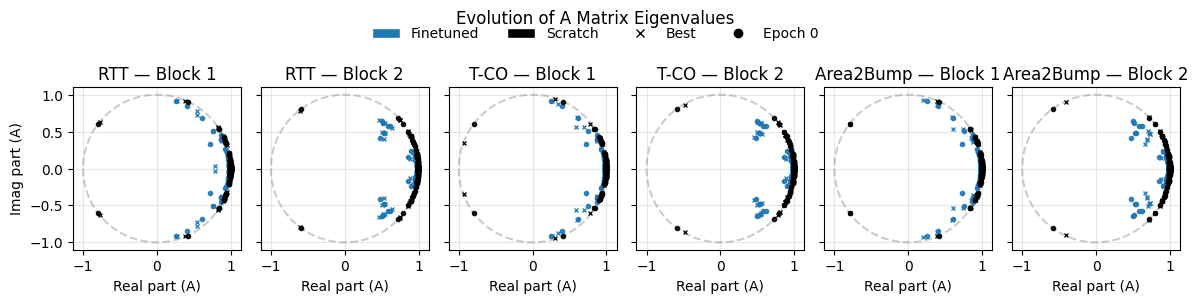

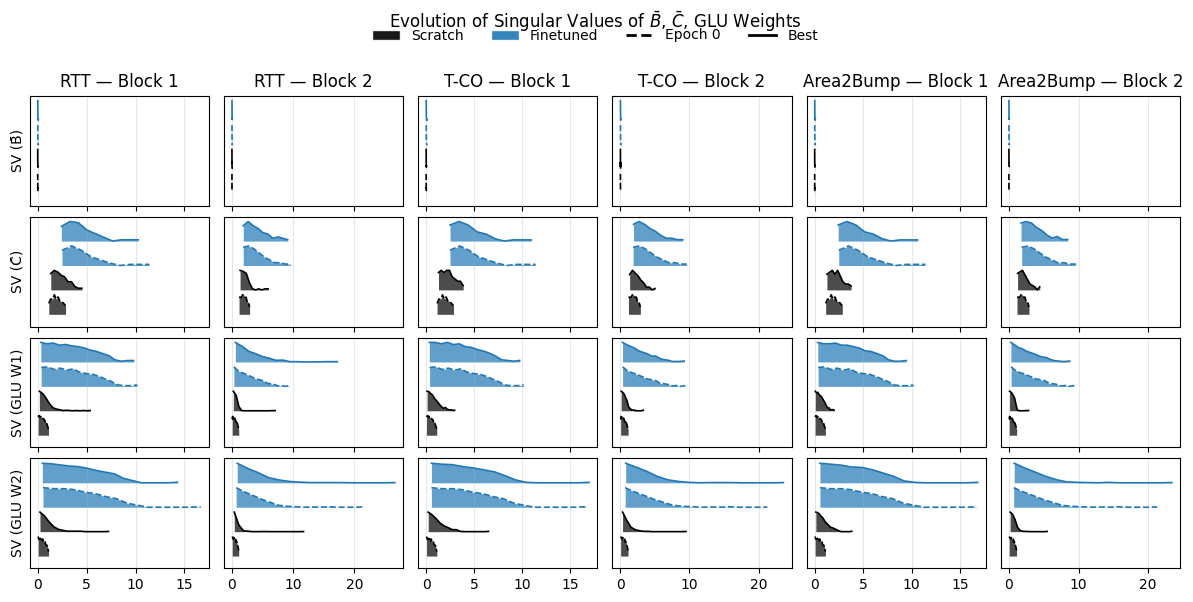

In [76]:
dataset_names = [
    "mc_rtt_prepend",
    "t_20130903_center_out_reaching",
    "mc_area2bump_prepend",
]

figE, figSV = plot_downstream_singular_value_evolution_combined(
    dataset_names, save_dir=WRITE_FIG_DIR
)
figE.show()
figSV.show()

In [9]:
figE.savefig(
    os.path.join(WRITE_FIG_DIR, "rtt_evolution_1SWindow_eigenvalues_A.pdf"), dpi=300
)
figSV.savefig(
    os.path.join(WRITE_FIG_DIR, "rtt_evolution_1SWindow_singular_values.pdf"), dpi=300
)